In [19]:
from leo_segmentation.data import Datagenerator, TrainingStats
from leo_segmentation.model import LEO, load_model, save_model
from leo_segmentation.utils import load_config, check_experiment, get_named_dict, \
                        log_data, list_to_tensor
from run import train_model
from easydict import EasyDict as edict
from torch.utils.tensorboard import SummaryWriter
from IPython import get_ipython
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import os, argparse, time

In [2]:
config = load_config()
leo = train_model(config)

num tasks: 5
tr_imgs shape: (5, 2, 384, 512, 3),tr_masks shape: (5, 2, 384, 512), val_imgs shape: (5, 5, 384, 512, 3), val_masks shape: (5, 5, 384, 512)
num tasks: 5
tr_imgs shape: (5, 2, 384, 512, 3),tr_masks shape: (5, 2, 384, 512), val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


115it [00:11,  9.65it/s]
202it [00:19, 10.15it/s]
87it [00:08, 10.16it/s]


102it [00:10,  9.98it/s]


585it [00:59,  9.84it/s]



mode:meta_val, episode:001, kl_loss:0.000000, total_meta_val_loss:0.698692 
val_mean_iou:{   'diningtable': 0.13513529998944454,
    'dog': 0.14194582450398877,
    'horse': 0.09402283942219741,
    'motorbike': 0.08785411051069857,
    'person': 0.09511009363413682}

Episode: 1, Episode Time: 2.663 minutes

num tasks: 5
tr_imgs shape: (5, 2, 384, 512, 3),tr_masks shape: (5, 2, 384, 512), val_imgs shape: 5 list of paths, val_masks shape: 5 list of paths


114it [00:11,  9.89it/s]


107it [00:10, 10.47it/s]


87it [00:08, 10.39it/s]


104it [00:10, 10.08it/s]


124it [00:12,  9.59it/s]


mode:meta_test, episode:001, kl_loss:0.000000, total_meta_test_loss:0.704570 
val_mean_iou:{   'pottedplant': 0.050723015522056034,
    'sheep': 0.12793244547607838,
    'sofa': 0.08138463622855314,
    'train': 0.09711430358943704,
    'tvmonitor': 0.09979294505004067}

Total Model Training Time 2.663 minutes



## Evaluation

In [8]:
mode = "meta_val"
dataset ="pascal_voc_raw"
dataloader = Datagenerator(config, dataset, data_type=mode)
img_transformer = dataloader.transform_image
mask_transformer = dataloader.transform_mask
transformers = (img_transformer, mask_transformer)
val_meta_data = dataloader.get_batch_data()
class_in_metadata = val_meta_data[4]
print(f"classes in mode {mode}: {class_in_metadata}")

classes in mode meta_val: ['dog', 'diningtable', 'person', 'motorbike', 'horse']


In [26]:
select_class = 0
pred_data_index = list(range(5))
print("class", class_in_metadata[select_class], "is selected")
batch_data = get_named_dict(val_meta_data, select_class)

class dog is selected


In [28]:
#perform forward_propagate and perform innerloop updates to generate weights
seg_weight_grad, features = leo.leo_inner_loop(batch_data.tr_imgs, batch_data.tr_masks)
#fine tune the weights
tr_val_loss, seg_weight_grad, decoder_gradients, tr_prediction, weight = \
            leo.finetuning_inner_loop(batch_data, features, seg_weight_grad, mode)

#prepare validation set
if type(pred_data_index) == list:
    input_embedding = np.vstack([list_to_tensor(batch_data.val_imgs[i], img_transformer) \
                                 for i in pred_data_index])
    input_mask = np.vstack([list_to_tensor(batch_data.val_masks[i], mask_transformer) \
                            for i in pred_data_index])
else:
    input_embedding = list_to_tensor(batch_data.val_imgs[pred_data_index], img_transformer)
    input_mask = list_to_tensor(batch_data.val_masks[pred_data_index], mask_transformer)

#predict on training data
encoder_outputs = leo.forward_encoder(input_embedding)
features = leo.forward_decoder(encoder_outputs)
val_prediction = leo.forward_segnetwork(features, input_embedding, weight)
val_predictions = np.argmax(input_embedding, -1) 

In [29]:
def plot_batch_mask(embeds, preds, masks, emb_channels):
    fig = plt.figure(figsize=(20,16))
    for i in range(0, len(preds)):
        embed = np.squeeze(embeds) if len(embeds) == 1 else embeds[i]
        pred = np.squeeze(preds) if len(preds) == 1 else preds[i]
        mask = np.squeeze(masks) if len(masks) == 1 else masks[i]
        
        fig.add_subplot(len(preds), 3, i*3+1)
        plt.imshow(embed)
        plt.title("3 embeddings_channels")
        
        fig.add_subplot(len(preds), 3, i*3+2)
        plt.imshow(mask, cmap="gray")
        plt.title("ground_truth")
        
        fig.add_subplot(len(preds), 3, i*3+3)
        plt.imshow(pred, cmap="gray")
        plt.title("prediction")
        
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


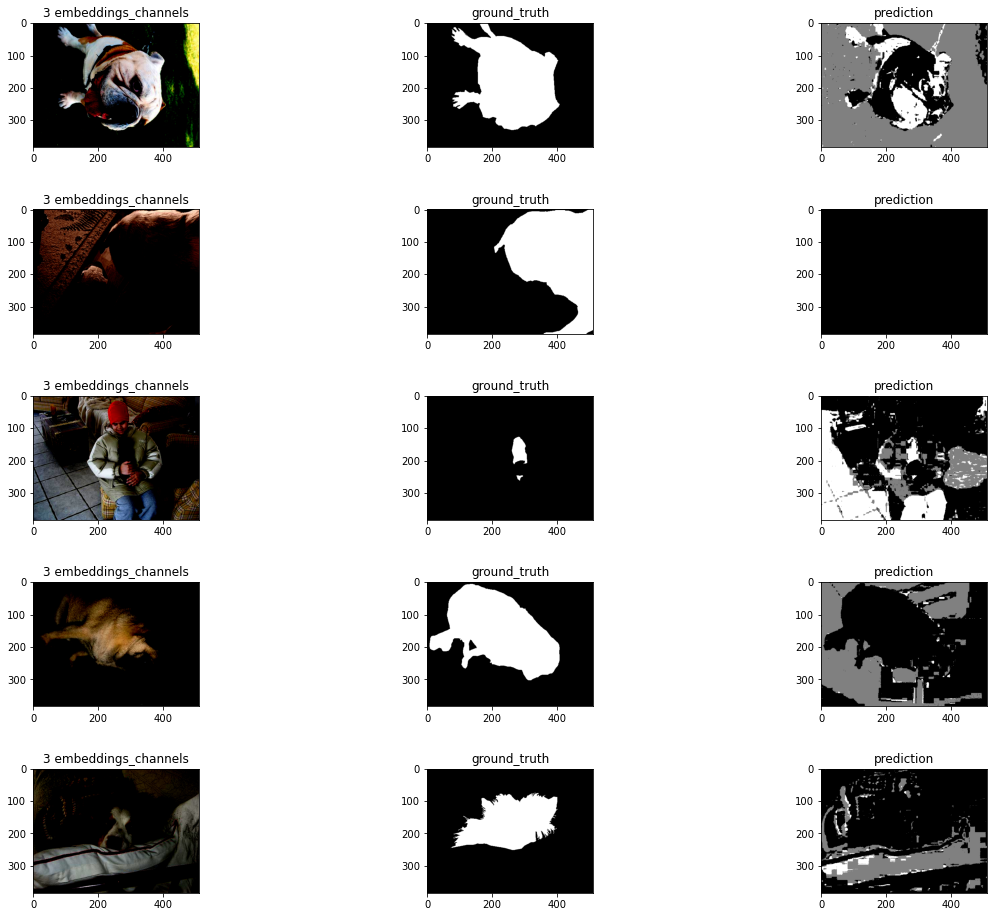

In [30]:
plot_batch_mask(input_embedding, val_predictions, input_mask, channels_to_view)